# 🌫️ AQI Prediction Notebook

👋 Hey there! I'm **Sheema**, a passionate Machine Learning enthusiast and AI Engineer in the making 💻🤖.  
Currently diving deep into real-world projects and building scalable, smart systems — and this is one of them!

In this notebook, I'm building an **End-to-End AQI Prediction System** that will:
- ✅ Collect **real-time AQI and weather data**
- 🔄 Automate data fetching using APIs
- 📊 Perform **detailed EDA** (exploratory data analysis)
- 🧠 Train ML models to predict AQI for the **next 3 days**
- 📈 Visualize trends, feature importance, and predictions
- 🚨 Raise alerts for hazardous AQI levels

This isn't just a project — it's my learning journal, my playground, and a showcase of how real-world AI solutions come to life 🌍💨

![AQI World Map](https://www.manoramayearbook.in/content/dam/yearbook/learn/world/images/2023/November/aqi.jpg)


Let’s begin!


### Import Required Libraries

In [1]:
# =========================
# 📦 Core Libraries
# =========================
import os
import json
import requests
import joblib
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# =========================
# 📊 Visualization & EDA
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 🤖 Scikit-learn Utilities
# =========================
from sklearn.model_selection import (
    train_test_split, KFold, TimeSeriesSplit, cross_val_score
)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, make_scorer
)

# =========================
# 🔥 XGBoost (if available)
# =========================
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    print("⚠️ XGBoost not available. Skipping XGBRegressor.")
    xgb_available = False

# =========================
# ⚠️ Warning Configuration
# =========================
import warnings
warnings.filterwarnings('ignore')

# =========================
# 🔁 Reproducibility
# =========================
np.random.seed(42)


In [4]:
# Set display settings
pd.set_option('display.max_columns', None)

# Load the dataset

df = pd.read_csv("/kaggle/input/karachi-daily-aqi-weather/karachi_daily_aqi_weather.csv")


# Convert date column
df['date'] = pd.to_datetime(df['date'])

#show
df.head()

,date,AQI,PM2.5,PM10,NO2,SO2,CO,O3,Temperature,Humidity,Precipitation,Next_Day_AQI
0,2023-01-01,129.583333,38.462500,69.537500,36.354167,33.379167,782.708333,84.916667,19.875000,65.375000,0.0,119.416667
1,2023-01-02,119.416667,59.991667,98.883333,47.241667,49.362500,905.708333,71.708333,19.725000,51.583333,0.0,153.000000
2,2023-01-03,153.000000,51.512500,77.683333,25.275000,27.154167,542.708333,80.125000,19.750000,36.458333,0.0,117.208333
3,2023-01-04,117.208333,40.720833,60.787500,18.004167,25.825000,466.625000,94.541667,18.866667,33.041667,0.0,119.958333
4,2023-01-05,119.958333,43.608333,63.775000,14.416667,28.462500,487.625000,103.041667,17.487500,31.666667,0.0,121.750000


In [5]:
# Check for Missing Values

df.isnull().sum()


date             0
AQI              0
PM2.5            0
PM10             0
NO2              0
SO2              0
CO               0
O3               0
Temperature      1
Humidity         1
Precipitation    1
Next_Day_AQI     1
dtype: int64

In [6]:
df.fillna(method='ffill', inplace=True)


In [7]:
# Basic Dataset Info

print("Shape of data:", df.shape)
print("\n📋 Column Summary:")
print(df.info())

# Descriptive statistics
df.describe()


Shape of data: (948, 12)

📋 Column Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           948 non-null    datetime64[ns]
 1   AQI            948 non-null    float64       
 2   PM2.5          948 non-null    float64       
 3   PM10           948 non-null    float64       
 4   NO2            948 non-null    float64       
 5   SO2            948 non-null    float64       
 6   CO             948 non-null    float64       
 7   O3             948 non-null    float64       
 8   Temperature    948 non-null    float64       
 9   Humidity       948 non-null    float64       
 10  Precipitation  948 non-null    float64       
 11  Next_Day_AQI   948 non-null    float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 89.0 KB
None


,date,AQI,PM2.5,PM10,NO2,SO2,CO,O3,Temperature,Humidity,Precipitation,Next_Day_AQI
count,948,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000
mean,2024-04-18 11:59:59.999999744,87.896009,29.207388,65.964201,19.472253,14.070302,449.393416,74.633263,26.571611,66.152470,0.020899,87.826433
min,2023-01-01 00:00:00,38.791667,8.520833,12.154167,3.462500,3.070833,119.166667,34.583333,14.841667,13.833333,0.000000,38.791667
25%,2023-08-25 18:00:00,67.697917,19.593750,44.611458,9.944792,5.994792,215.614583,59.375000,23.475000,56.510417,0.000000,67.645833
50%,2024-04-18 12:00:00,80.125000,25.352083,58.127083,15.702083,11.752083,337.812500,71.770833,27.768750,72.791667,0.000000,80.083333
75%,2024-12-11 06:00:00,99.375000,34.009375,77.917708,26.204167,18.330208,616.854167,86.354167,29.879167,77.677083,0.000000,99.333333
max,2025-08-05 00:00:00,214.625000,119.770833,294.483333,97.483333,84.108333,2022.958333,200.625000,33.291667,90.250000,2.133333,214.625000
std,NaN,28.630164,14.725431,32.501435,12.531271,10.549658,310.861827,21.292042,4.039696,16.114903,0.119442,28.608887


##  AQI Trend Over Time with WHO Zones

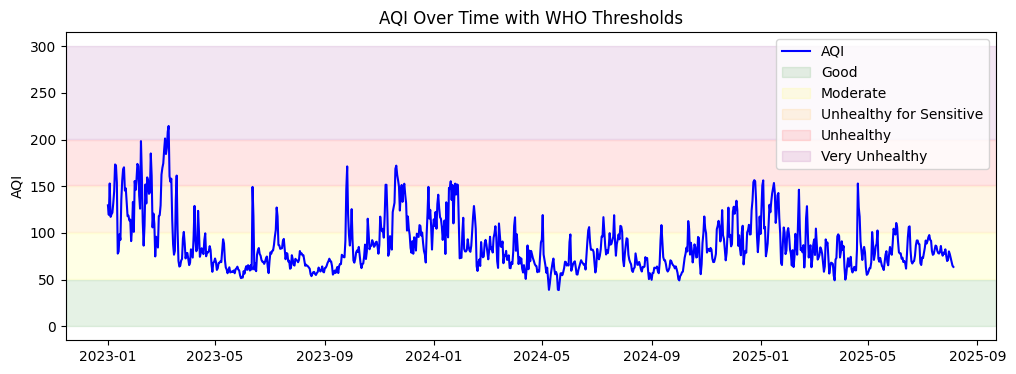

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['AQI'], color='blue', label='AQI')
plt.axhspan(0, 50, color='green', alpha=0.1, label='Good')
plt.axhspan(51, 100, color='yellow', alpha=0.1, label='Moderate')
plt.axhspan(101, 150, color='orange', alpha=0.1, label='Unhealthy for Sensitive')
plt.axhspan(151, 200, color='red', alpha=0.1, label='Unhealthy')
plt.axhspan(201, 300, color='purple', alpha=0.1, label='Very Unhealthy')
plt.legend()
plt.title('AQI Over Time with WHO Thresholds')
plt.ylabel('AQI')
plt.show()


### 📈 Karachi AQI Trend Over Time (2023–2025)

**Chart Insight: AQI Over Time**

- **Fluctuating AQI:** The AQI in Karachi shows **high variability** over the 2.5-year period.
- **Peak Pollution Periods:**
  - **Early 2023** and **Late 2023 to Early 2024** saw **frequent AQI spikes above 150–200**, indicating **unhealthy air quality**.
- **Relatively Stable Periods:**
  - Mid-2023 and mid-2024 had **lower and more stable AQI**, generally within the **moderate range (50–100)**.

**Implications:**
- **Seasonal Variation** is evident — AQI tends to rise in **winter months**, likely due to:
  - Temperature inversions
  - Increased heating-related emissions
  - Reduced wind dispersion
- The **general trend in 2025** shows some improvement but still fluctuates above the safe limit.

> Regular AQI spikes suggest that short-term events (weather, traffic, industry) have a strong influence on air quality. Long-term mitigation requires addressing both **seasonal** and **episodic sources**.


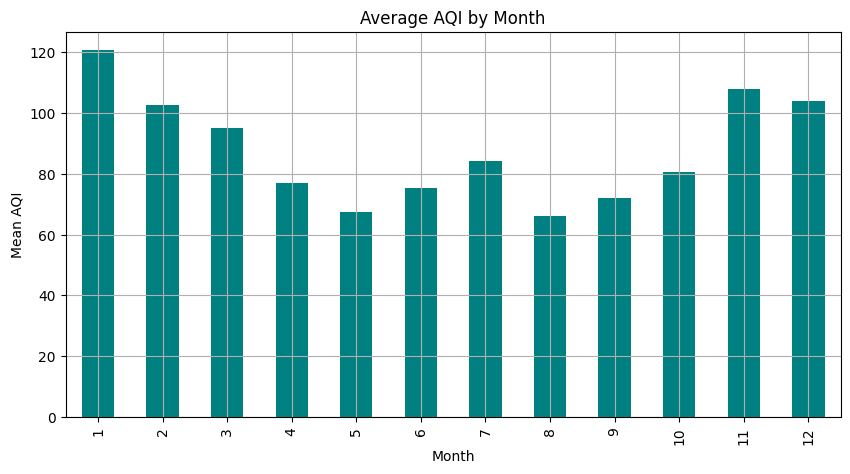

In [12]:
# AQI by Month

df['month'] = df['date'].dt.month

monthly_avg = df.groupby('month')['AQI'].mean()

plt.figure(figsize=(10,5))
monthly_avg.plot(kind='bar', color='teal')
plt.title("Average AQI by Month")
plt.xlabel("Month")
plt.ylabel("Mean AQI")
plt.grid(True)
plt.savefig("Average AQI by Month.png")
plt.show()



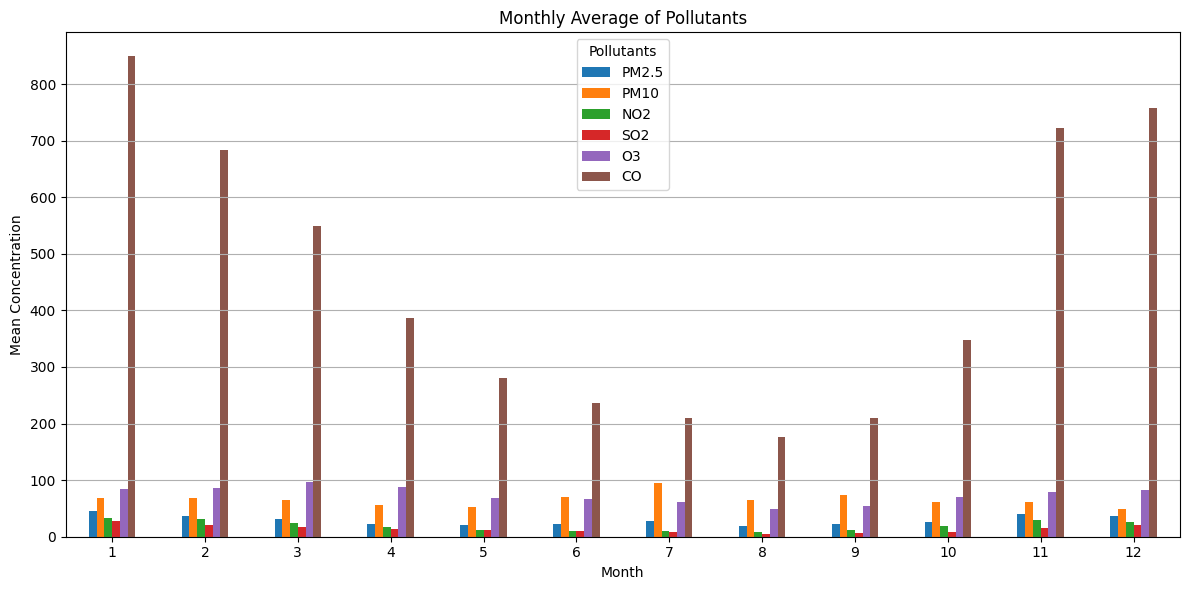

In [13]:
# Ensure date column is datetime
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

# List of pollutant columns (update as per your dataset)
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', "O3", 'CO']

# Group by month and calculate average for each pollutant
monthly_avg = df.groupby('month')[pollutants].mean()

# Plotting
ax = monthly_avg.plot(kind='bar', figsize=(12,6))  # Clustered bars
plt.title("Monthly Average of Pollutants")
plt.xlabel("Month")
plt.ylabel("Mean Concentration")
plt.grid(True, axis='y')
plt.legend(title='Pollutants')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("Monthly_Average_Pollutants.png")
plt.show()


### 📊 Karachi AQI & Pollutant Analysis (Monthly)

#### 🌡️ Seasonal Patterns:
- **Winter months (Jan, Nov, Dec)** show **highest AQI and pollutant concentrations**, especially **CO**, indicating increased emissions likely due to traffic, heating, and weather conditions (low wind, temperature inversion).
- **Summer months (Apr–Aug)** have the **lowest AQI levels** (~65–75), suggesting **better air dispersion** and improved air quality.
- **Transitional months** (Mar, Oct) show **moderate pollution**, marking gradual seasonal shifts.

#### 🧪 Pollutant Insights:
- **CO** dominates the pollutant profile across all months, with sharp peaks in **Jan and Dec**.
- **PM10** and **O3** are consistently present in moderate concentrations.
- **SO2** and **NO2** show minor seasonal variations, slightly higher in colder months.
- **PM2.5** remains below PM10 but often above safe thresholds.

> ✅ **Policy Recommendation**: Focus pollution control efforts between **October and February** to reduce winter health risks.


## Pollutants  (PM2.5, PM10, CO, etc.)
 - pollutants contibution
 - pollutants distribution
 - poluutants average concentration


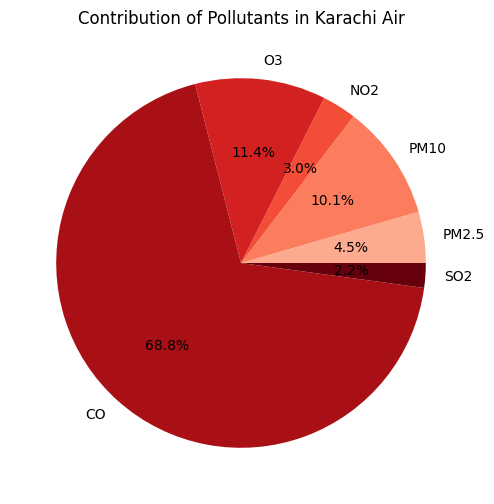

In [16]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'O3', 'CO', 'SO2']
avg_values = df[pollutants].mean()

plt.figure(figsize=(6, 6))
plt.pie(avg_values, labels=pollutants, autopct='%1.1f%%',
        colors=plt.cm.Reds(np.linspace(0.3, 1, len(pollutants))))
plt.title('Contribution of Pollutants in Karachi Air')
plt.show()


### 🍩 Pollutant Contribution Analysis – Karachi

- **CO (68.9%)** is the **dominant pollutant**, making up over two-thirds of total air composition.
- **O3 (11.4%)** and **PM10 (10.1%)** follow, contributing moderate shares.
- **PM2.5 (4.5%)**, though smaller in share, is more harmful due to fine particle size.
- **NO2 (3.0%)** and **SO2 (2.2%)** have minimal presence but can still pose health risks.
  
➡️ **Insight:** CO dominates, but **PM2.5** and **PM10** require attention due to their **high health impact** despite lower percentage.


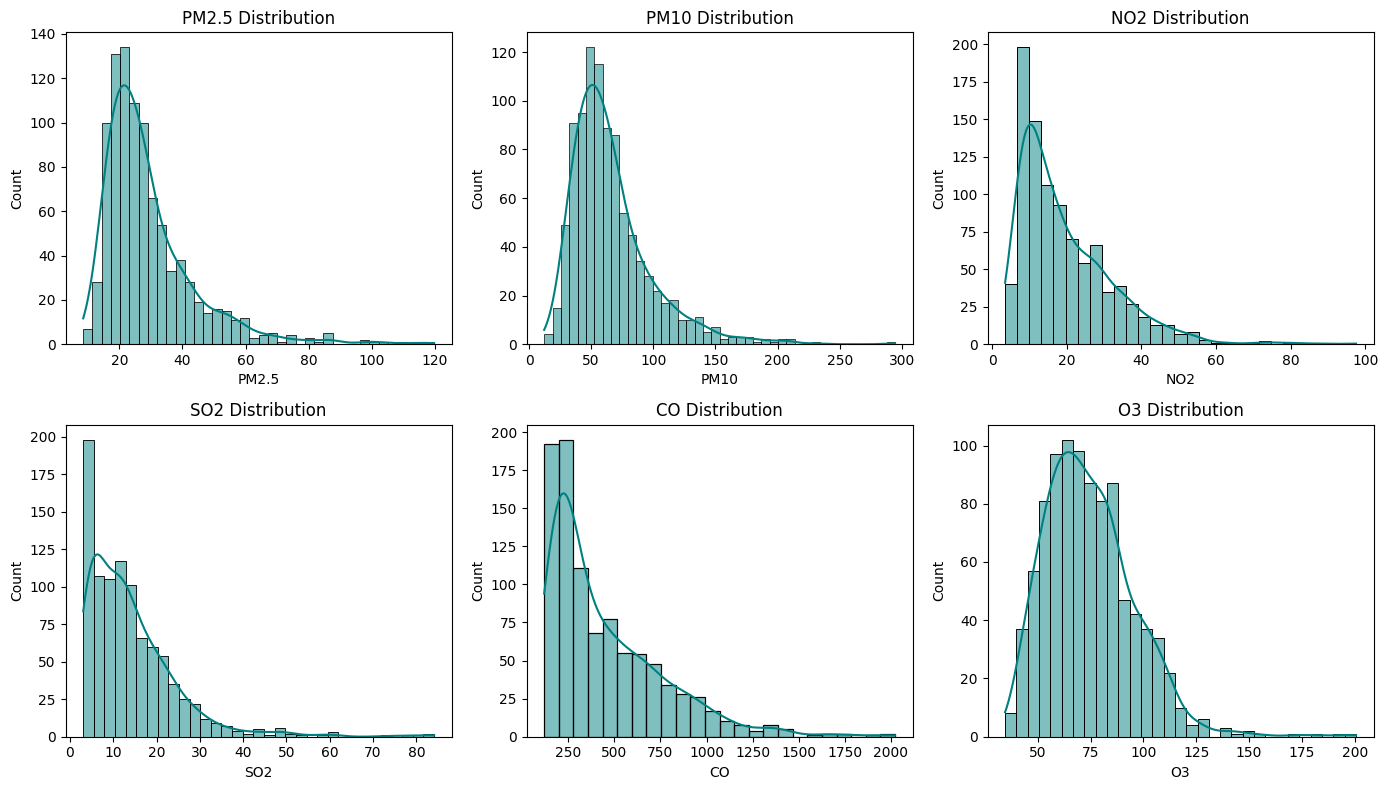

In [17]:
# Pollutant Distribution (PM2.5, PM10, CO, etc.)

pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']

plt.figure(figsize=(14,8))
for i, col in enumerate(pollutants):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True, color='teal')
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.savefig("Pollutants Distribution.png")
plt.show()


### 📊 Distribution of Pollutants in Karachi

**Chart Insight: Histogram + KDE of Individual Pollutants**

- **Skewed Distributions:** All pollutant distributions are **right-skewed**, indicating that:
  - Most values are clustered at the lower end.
  - There are a few extreme high values (outliers).

**Individual Observations:**
- **PM2.5, PM10, NO₂, SO₂:**  
  - Peak at lower concentration ranges (10–40).
  - Heavy tail suggests occasional pollution spikes.

- **CO:**  
  - Very wide range with a peak around **250–400**, but extends beyond **1500**, highlighting **extreme outlier events**.
  - Reinforces its critical role in Karachi's air quality issues.

- **O₃ (Ozone):**  
  - More normally distributed than others, with most values between **60–100**.

**Implication:**
- **Frequent low to moderate pollution levels**, but occasional **severe pollution spikes** need targeted policy and emergency response.
- **CO outliers** are especially concerning for public health and require source-specific investigation.


Most critical pollutant in Karachi: CO (Average concentration: 449.39)


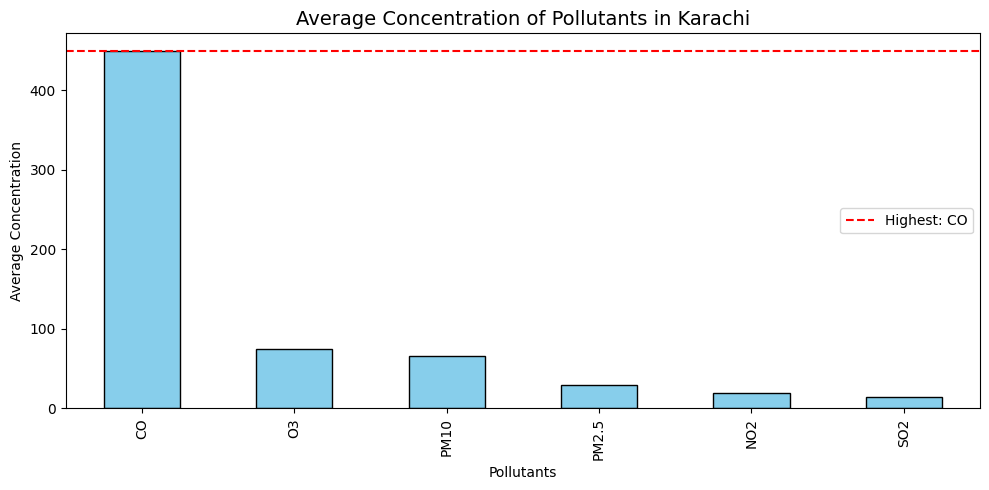

In [14]:
# Define your pollutants
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']

# Calculate average concentration of each pollutant
avg_concentrations = df[pollutants].mean().sort_values(ascending=False)

# Identify the most critical one
most_critical = avg_concentrations.idxmax()
most_value = avg_concentrations.max()

# Print result
print('='*60)
print(f"Most critical pollutant in Karachi: {most_critical} (Average concentration: {most_value:.2f})")
print('='*60)

# Plot
plt.figure(figsize=(10, 5))
avg_concentrations.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Concentration of Pollutants in Karachi', fontsize=14)
plt.ylabel('Average Concentration')
plt.xlabel('Pollutants')
plt.axhline(y=most_value, color='red', linestyle='--', label=f'Highest: {most_critical}')
plt.legend()
plt.tight_layout()
plt.savefig('Average Concentration of Pollutants in Karachi.png')
plt.show()


### 🔍 Pollutant Concentration Analysis – Karachi

**Chart Insight: Average Concentration of Pollutants in Karachi**

- **Most Critical Pollutant:** CO (Carbon Monoxide) with an average concentration of **452.69**, significantly higher than all other pollutants.
- **Other Pollutants:**  
  - O₃ and PM10 are the next highest but still far lower than CO.
  - PM2.5, NO₂, and SO₂ show relatively low average concentrations.

**Implication:**
- The **extremely high concentration of CO** suggests a major contribution from **vehicular emissions and industrial activity**.
- Immediate interventions are needed to reduce CO levels to avoid severe health impacts.

> CO's dominance in the pollutant profile indicates it should be the primary target in Karachi's air quality improvement policies.

-------------------------

## 📉 Pollutant Comparison – Karachi vs WHO Standards


📊 WHO Air Quality Limit Comparison for Karachi


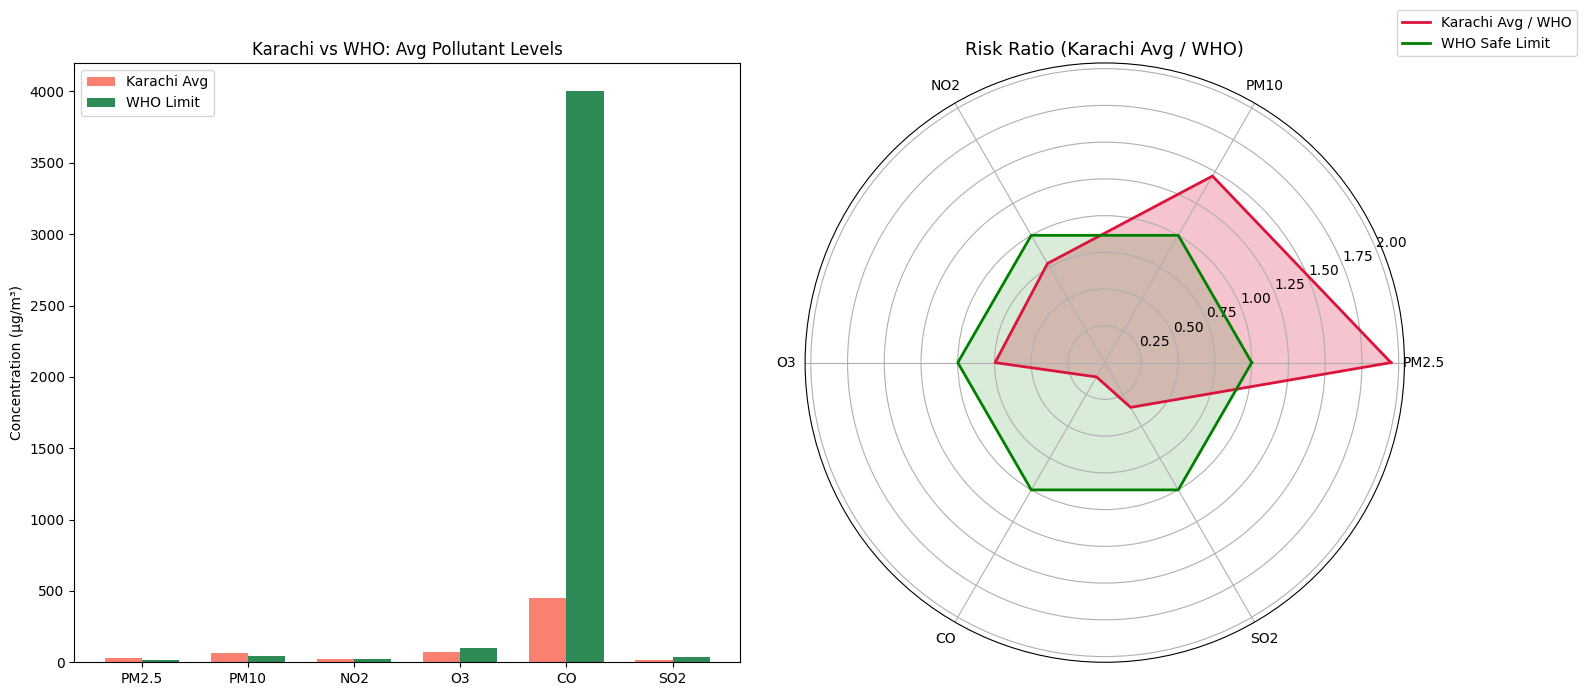

In [15]:
def who_limit_comparison(df):
    """
    Compare Karachi's average pollutant levels with WHO safety limits.
    Shows both bar chart and radar chart side by side.
    """
    print("\n📊 WHO Air Quality Limit Comparison for Karachi")
    print("=" * 60)

    # Define pollutants
    pollutants = ['PM2.5', 'PM10', 'NO2', 'O3', 'CO', 'SO2']

    # WHO safe limits (converted where needed)
    who_limits = pd.Series({
        'PM2.5': 15,     # µg/m³
        'PM10': 45,
        'NO2': 25,
        'O3': 100,
        'CO': 4000,      # CO in µg/m³ (4 mg/m³)
        'SO2': 40
    })

    # Average pollutant values from Karachi data
    karachi_avg = df[pollutants].mean()
    karachi_ratio = karachi_avg / who_limits
    who_ratio = pd.Series([1.0] * len(pollutants), index=pollutants)

    # Prepare radar chart angles
    angles = np.linspace(0, 2 * np.pi, len(pollutants), endpoint=False).tolist()
    angles += angles[:1]

    karachi_plot = karachi_ratio.tolist() + karachi_ratio.tolist()[:1]
    who_plot = who_ratio.tolist() + who_ratio.tolist()[:1]

    # Create side-by-side plots
    fig = plt.figure(figsize=(16, 7))

    # 📈 Bar Chart
    ax1 = fig.add_subplot(1, 2, 1)
    x = np.arange(len(pollutants))
    width = 0.35
    ax1.bar(x - width/2, karachi_avg[pollutants], width, label='Karachi Avg', color='salmon')
    ax1.bar(x + width/2, who_limits[pollutants], width, label='WHO Limit', color='seagreen')

    ax1.set_xticks(x)
    ax1.set_xticklabels(pollutants)
    ax1.set_ylabel('Concentration (µg/m³)')
    ax1.set_title('Karachi vs WHO: Avg Pollutant Levels')
    ax1.legend()

    # 📊 Radar Chart
    ax2 = fig.add_subplot(1, 2, 2, polar=True)
    ax2.plot(angles, karachi_plot, color='crimson', linewidth=2, label='Karachi Avg / WHO')
    ax2.fill(angles, karachi_plot, color='crimson', alpha=0.25)

    ax2.plot(angles, who_plot, color='green', linewidth=2, label='WHO Safe Limit')
    ax2.fill(angles, who_plot, color='green', alpha=0.15)

    ax2.set_thetagrids(np.degrees(angles[:-1]), pollutants)
    ax2.set_title('Risk Ratio (Karachi Avg / WHO)', fontsize=13)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout()
    plt.savefig('Side-by-Side WHO Comparison Charts.png')
    plt.show()


who_limit_comparison(df)

#### 📊 Bar Chart: Karachi Avg vs WHO Safe Limits
- Direct comparison of **absolute pollutant concentrations (µg/m³)**.
- **Key Observations**:
  - **PM2.5 & PM10** → 🚨 Significantly exceed WHO thresholds.
  - **NO₂** → Slightly above limit.
  - **CO** → Appears safe, but WHO limit is quite lenient (4000 µg/m³).
  - **SO₂ & O₃** → Within or near acceptable range.

🧾 **Note**: This chart focuses on *how much* pollutant is present in the air compared to WHO standards.

---

### 🌍 Air Quality Risk Comparison: Karachi vs WHO – Radar Chart Insights

#### 📈 Radar Chart: Risk Ratio (Karachi Avg / WHO Limit)
- Shows **how far each pollutant exceeds (or stays within)** safe limits.

**Key Ratios:**
- **PM2.5 & PM10** → Risk Ratio **> 1.5** → Major health concern.
- **NO₂** → Slightly over WHO limit (Risk ~1.1–1.2).
- **O₃, CO, SO₂** → Risk Ratio **< 1.0** → Currently under control.

🧾 **Note**: Radar chart helps visualize *relative risk* — even if actual values are low, high ratios mean the standard is breached.

---

### 📌 Summary & Recommendations

- 🚨 **Top Priority Pollutants**:  
  - **PM2.5**, **PM10**, **NO₂**  
  - Linked to respiratory illness, asthma, and poor urban air quality.

- ✅ **Safe or Manageable**:  
  - **CO**, **O₃**, **SO₂**

- 🛠️ **Recommendations**:  
  - Reduce **dust, vehicle exhaust, industrial smoke**.  
  - Promote **green transport**, monitor **construction zones**, enforce **cleaner fuel policies**.

> 🔍 **Use both charts** for full insight:  
> - Bar Chart = Absolute pollutant levels  
> - Radar Chart = Risk compared to health safety limits


--------------------

## Correlation Analysis
 - correlation heatmap
 - correlation with AQI


📊 POLLUTANT CORRELATION ANALYSIS

🔥 STRONGEST CORRELATIONS (|corr| > 0.7):
----------------------------------------
AQI ↔ PM2.5: 0.913
PM2.5 ↔ Next_Day_AQI: 0.911
NO2 ↔ CO: 0.903
AQI ↔ Next_Day_AQI: 0.848
SO2 ↔ CO: 0.840
NO2 ↔ SO2: 0.820
PM2.5 ↔ CO: 0.737
PM2.5 ↔ SO2: 0.733
AQI ↔ CO: 0.719

🖼️ Displaying Correlation Heatmap...


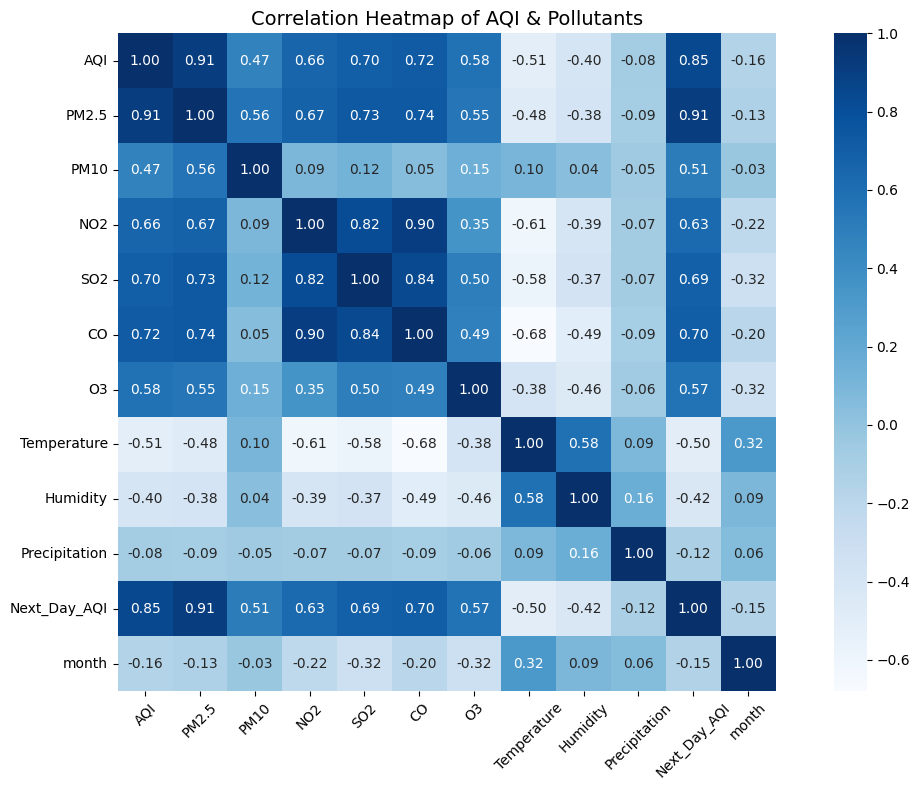


📈 Correlation of Features with AQI:
AQI              1.000000
PM2.5            0.913164
Next_Day_AQI     0.848111
CO               0.718846
SO2              0.696658
NO2              0.656228
O3               0.578872
PM10             0.474716
Precipitation   -0.079363
month           -0.157606
Humidity        -0.397262
Temperature     -0.505889
Name: AQI, dtype: float64


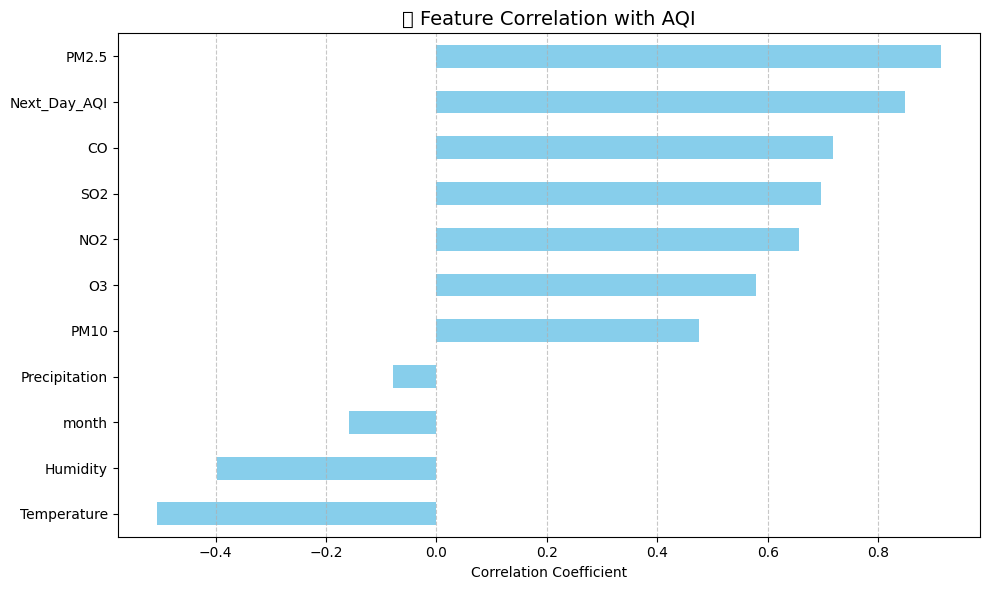

In [16]:
def correlation_analysis(df):
    """
    Perform correlation analysis between all features (including AQI),
    print strongest correlated pairs, show heatmap, and barplot of AQI correlations.
    """
    print("\n📊 POLLUTANT CORRELATION ANALYSIS")
    print("="*60)

    # Drop non-numeric columns
    df_numeric = df.drop(columns=['date'], errors='ignore')

    # Compute correlation matrix
    corr = df_numeric.corr()

    # Print strongest correlation pairs
    print("\n🔥 STRONGEST CORRELATIONS (|corr| > 0.7):")
    print("-" * 40)
    strong = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            val = corr.iloc[i, j]
            if abs(val) > 0.7:
                strong.append((corr.index[i], corr.columns[j], val))
    for var1, var2, val in sorted(strong, key=lambda x: abs(x[2]), reverse=True):
        print(f"{var1} ↔ {var2}: {val:.3f}")

    # Heatmap
    print("\n🖼️ Displaying Correlation Heatmap...")
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f", square=True)
    plt.title("Correlation Heatmap of AQI & Pollutants", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("Correlation Heatmap of AQI & Pollutants.png")
    plt.show()

    # AQI Correlation Bar Plot
    if 'AQI' in corr.columns:
        print("\n📈 Correlation of Features with AQI:")
        corr_with_aqi = corr['AQI'].sort_values(ascending=False)
        print(corr_with_aqi)

        plt.figure(figsize=(10, 6))
        corr_with_aqi.drop('AQI').plot(kind='barh', color='skyblue')
        plt.title('🔍 Feature Correlation with AQI', fontsize=14)
        plt.xlabel('Correlation Coefficient')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig("Feature Correlation with AQI.png")
        plt.show()
    else:
        print("⚠️ 'AQI' column not found in the dataset.")

# Call the function
correlation_analysis(df)


### 🌫️ Karachi AQI – Final Correlation Insights

#### 🔺 Strong Positive Correlations (↑ AQI with ↑ feature):
- **PM2.5 (0.91)**: 🚨 *Most significant pollutant impacting air quality.*
- **Next_Day_AQI (0.85)**: ⏳ *Strong temporal dependency — supports time-series prediction.*
- **CO (0.72)**: 🛑 *Major contributor — common urban pollutant.*
- **SO₂ (0.69)** & **NO₂ (0.65)**: ⚙️ *Industrial/vehicular sources add to AQI.*
- **O₃ (0.57)**: ☀️ *Secondary pollutant — moderate impact.*

#### ⚠️ Moderate Correlation:
- **PM10 (0.47)**: 🟡 *Less critical than PM2.5 but still contributes.*

#### 🔻 Negative Correlations (↓ AQI with ↑ feature):
- **Temperature (-0.51)**: ❄️ *Higher temperatures correlate with lower AQI — possible dispersion effect.*
- **Humidity (-0.39)**: 💧 *Moderate negative impact — more humidity → cleaner air.*
- **Month (-0.15)** & **Precipitation (-0.08)**: 🗓️🌧️ *Weak seasonal/weather effects.*


### So we can sum up :
- Prioritize **PM2.5, CO, NO₂, SO₂, O₃** as key predictors in modeling AQI.
- **Temperature & Humidity** act as natural suppressors of pollution — consider in inverse relationships.
- **Next_Day_AQI** shows **strong auto-correlation**, ideal for **time-series forecasting models (e.g., LSTM, ARIMA)**.

-------------

## 📉 AQI vs Temperature , Humidity and precipitation

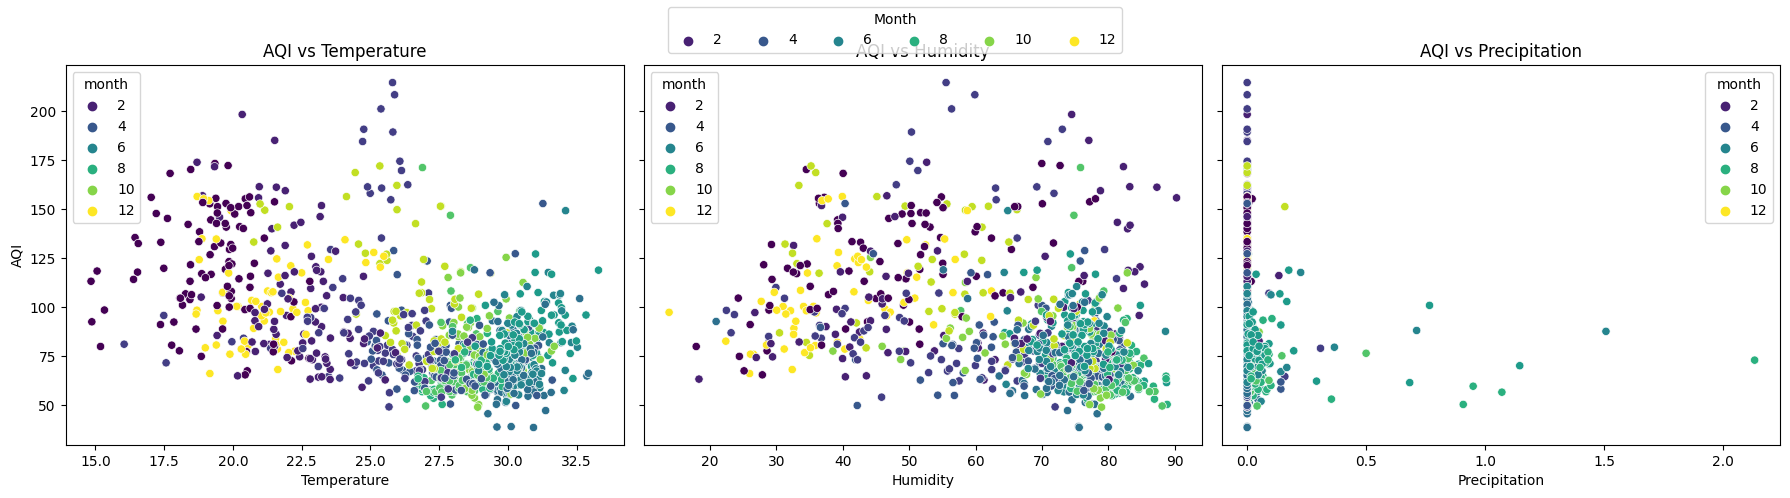

In [28]:
# ------------------ Combined Plot: AQI vs Temperature, Humidity, Precipitation ------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# AQI vs Temperature
sns.scatterplot(data=df, x='Temperature', y='AQI', hue='month', palette='viridis', ax=axes[0])
axes[0].set_title("AQI vs Temperature")
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("AQI")

# AQI vs Humidity
sns.scatterplot(data=df, x='Humidity', y='AQI', hue='month', palette='viridis', ax=axes[1])
axes[1].set_title("AQI vs Humidity")
axes[1].set_xlabel("Humidity")
axes[1].set_ylabel("")  # To avoid duplicate AQI labels

# AQI vs Precipitation
sns.scatterplot(data=df, x='Precipitation', y='AQI', hue='month', palette='viridis', ax=axes[2])
axes[2].set_title("AQI vs Precipitation")
axes[2].set_xlabel("Precipitation")
axes[2].set_ylabel("")

# Common formatting
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, title='Month', loc='upper center', ncol=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("aqi_vs_weather_factors.png")
plt.show()


### 🌡️ AQI vs Weather Factors - Karachi

#### 📈 AQI vs Temperature:
- **Negative correlation observed**: As **temperature increases**, **AQI tends to decrease**.
- Lower temperatures (especially in winter months like **Dec-Feb**) are associated with **higher AQI**, indicating poor air dispersion during colder months.

#### 💧 AQI vs Humidity:
- **Weak positive correlation**: AQI appears more scattered with humidity, but slightly **higher AQI values are seen with lower to mid humidity** levels.
- Most data is clustered between **50–80% humidity**, showing moderate impact.

#### 🌧️ AQI vs Precipitation:
- **Very low or no precipitation** correlates with **higher AQI**.
- **Rainfall appears to reduce AQI**, supporting the idea that **precipitation helps in pollutant removal (wet deposition)**.
- Most high AQI values are clustered at **zero or near-zero rainfall**.

> ✅ **Cooler, drier, and non-rainy conditions contribute to higher AQI levels. Weather-based early warnings and pollution control should be prioritized in such conditions.**


## GEneral Insights (Karachi AQI)

In [22]:
def karachi_insights(df):
    """Generate insights from Karachi AQI dataset"""

    print("\n🧠 ADVANCED ANALYTICS: KARACHI AQI")
    print("="*60)

    # AQI Summary
    print("\n📈 AQI SUMMARY STATS")
    print("-" * 40)
    print(f"Average AQI: {df['AQI'].mean():.2f}")
    print(f"Median AQI: {df['AQI'].median():.2f}")
    print(f"Standard Deviation: {df['AQI'].std():.2f}")
    print(f"Max AQI: {df['AQI'].max():.2f}")
    print(f"Min AQI: {df['AQI'].min():.2f}")

    # Weekday vs Weekend
    df['weekday'] = df['date'].dt.weekday
    df['day_name'] = df['date'].dt.day_name()
    df['is_weekend'] = df['weekday'].isin([5, 6])

    weekend_aqi = df.groupby('is_weekend')['AQI'].mean()
    print("\n📅 WEEKDAY vs WEEKEND AQI")
    print("-" * 40)
    print(f"Weekday AQI: {weekend_aqi[False]:.2f}")
    print(f"Weekend AQI: {weekend_aqi[True]:.2f}")

    # Seasonal AQI
    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Autumn'

    df['season'] = df['date'].dt.month.map(get_season)
    seasonal_aqi = df.groupby('season')['AQI'].mean().sort_values()

    print("\n🌱 SEASONAL AQI TRENDS")
    print("-" * 40)
    for season, value in seasonal_aqi.items():
        print(f"{season}: {value:.2f}")

    # Extreme AQI Days
    extreme_days = df[df['AQI'] > 150]

    print("\n⚠️ EXTREME AQI EVENTS (AQI > 150)")
    print("-" * 40)
    print(f"Total extreme days: {len(extreme_days)}")

    if not extreme_days.empty:
        worst = extreme_days.sort_values('AQI', ascending=False).iloc[0]
        print(f"\n🚨 WORST DAY")
        print(f"Date: {worst['date'].strftime('%Y-%m-%d')}")
        print(f"AQI: {worst['AQI']:.2f}")
        print(f"PM2.5: {worst['PM2.5']:.2f}")
        print(f"PM10: {worst['PM10']:.2f}")
    else:
        print("🎉 No AQI > 150 — air quality stayed moderate!")

    # WHO AQI Exceedance
    exceed_pct = (df['AQI'] > 100).mean() * 100
    print("\n📊 WHO AQI THRESHOLD ANALYSIS")
    print("-" * 40)
    print(f"Days exceeding WHO AQI safety (AQI > 100): {exceed_pct:.2f}%")

    print("="*60)


# Run the insights function
karachi_insights(df)


🧠 ADVANCED ANALYTICS: KARACHI AQI

📈 AQI SUMMARY STATS
----------------------------------------
Average AQI: 87.90
Median AQI: 80.12
Standard Deviation: 28.63
Max AQI: 214.62
Min AQI: 38.79

📅 WEEKDAY vs WEEKEND AQI
----------------------------------------
Weekday AQI: 87.95
Weekend AQI: 87.77

🌱 SEASONAL AQI TRENDS
----------------------------------------
Summer: 76.30
Spring: 79.87
Autumn: 86.83
Winter: 110.02

⚠️ EXTREME AQI EVENTS (AQI > 150)
----------------------------------------
Total extreme days: 52

🚨 WORST DAY
Date: 2023-03-10
AQI: 214.62
PM2.5: 87.06
PM10: 126.19

📊 WHO AQI THRESHOLD ANALYSIS
----------------------------------------
Days exceeding WHO AQI safety (AQI > 100): 24.37%


# 📦 Data Preparation Plan — Based on AQI Insights (Karachi)

We discovered several key patterns through our Exploratory Data Analysis (EDA). These insights will serve as the foundation for the following data preparation and modeling strategy:

---

## 🎯 Prediction Target

- AQI is **regression target** (numeric prediction).
- **Goal:** Next 3 days AQI prediction (multistep forecasting).

---

## ✅ Feature Selection — Rakhne Wale Features

- **PM2.5** (Top pollutant, highest correlation)
- **CO** (High impact, avg concentration bhi highest)
- **SO2, NO2, O3** (Moderate contributors)
- **PM10** (Dust source, relevant but less correlated)
- **Temperature, Humidity** (Negative correlation — lower AQI in hot/humid weather)
- **Month** (Seasonal impact)
- **Precipitation** (Weak correlation, lekin useful)

---

## 🚫 Features to drop (least important)

- **date** (sirf feature extraction ke liye)
- **Next_Day_AQI** (leakage risk)
- Unnecessary IDs, duplicates, raw timestamps

---

## 🛠️ Feature Engineering

- With Date : month, season, weekday
- One-hot encoding: season, weekday (if needed)
- Log-transform: skewed pollutants (PM2.5, CO)
- Scaling/Normalization: agar model ko zarurat ho (e.g., Linear Regression, KNN)

---

## ⚠️ Outlier Handling

- CO, PM2.5 me heavy right skew/outliers
- Log transformation/IQR-based capping apply karna

---

## 🔀 Train-Test Split Strategy

- **Standard ML:** Random 80/20 split
- **Time Series Models:** Time-based validation (expanding window/rolling forecast)

---

## 🤖 Modeling Direction

- **Linear Regression:** Baseline + interpretability
- **Random Forest / XGBoost:** For Handling Non-linear impacts
- **LSTM / Prophet (optional):** Agar true time-series prediction karni ho

---

## 🧠 Final Thoughts — Summary Table

| Insight                                | Action                        |
|----------------------------------------|-------------------------------|
| PM2.5, CO, SO2, NO2 → Strong AQI predictors | Keep                     |
| Temperature, Humidity → Lower AQI           | Keep                     |
| Next_Day_AQI → Leakage risk                 | Drop                     |
| Seasonal impact                             | Extract season           |
| Outliers in pollutants                      | Log/IQR transform        |
| Predict next 3 AQI values                   | New target columns       |

**Data prepration ka goal:**  
- Relevant features select karna  
- Leakage avoid karna  
- Skew/outliers handle karna  
- Model ko future AQI values predict karne ke liye ready karna hai

---------------------------------

---
--------
# 📊 Preprocess Data
---
-----



In [29]:
# Paths
RAW_DATA_PATH = "/kaggle/input/karachi-daily-aqi-weather/karachi_daily_aqi_weather.csv"
PROCESSED_DATA_PATH = "processed_data/daily_karachi_preprocessed.csv"

# Ensure output directory exists
os.makedirs("processed_data", exist_ok=True)

print("📥 Loading data...")
df = pd.read_csv(RAW_DATA_PATH)
print(f"✅ Data loaded. Shape: {df.shape}")

# --- Remove Duplicates ---
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"🧹 Removed duplicates: {before - after} rows")

# --- Fill missing values ---
null_before = df.isnull().sum().sum()
df = df.ffill()
null_after = df.isnull().sum().sum()
print(f"🔧 Nulls before: {null_before}, after forward fill: {null_after}")

# --- Feature Engineering from Date ---
print("🛠️ Feature engineering on date...")
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.month
df["weekday"] = df["date"].dt.weekday

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df["season"] = df["month"].apply(get_season)
print("✅ Added: month, weekday, season")

# --- Drop unnecessary columns ---
cols_to_drop = ["Next_Day_AQI"]
for col in cols_to_drop:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
        print(f"🗑️ Dropped column: {col}")
    else:
        print(f"⚠️ Column not found (already removed or missing): {col}")

# --- Log Transform skewed features ---
for col in ["PM2.5", "CO"]:
    if col in df.columns:
        df[f"log_{col}"] = np.log1p(df[col])
        df.drop(columns=[col], inplace=True)
        print(f"🔁 Log transformed and dropped: {col}")

# --- IQR Capping for outliers ---
def iqr_cap(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[column].clip(lower, upper)

print("📏 Applying IQR capping...")
for col in ["PM10", "SO2", "NO2", "O3", "Temperature", "Humidity", "Precipitation"]:
    if col in df.columns:
        df[col] = iqr_cap(df, col)
        print(f"✅ IQR capped: {col}")

# --- One-hot encode season and weekday ---
print("🎨 One-hot encoding season and weekday...")
df = pd.get_dummies(df, columns=["season", "weekday"], drop_first=True)
print("✅ Encoding done.")

# --- Create Multi-Step Targets ---
print("⏭️ Creating AQI_t+1, t+2, t+3...")
df["AQI_t+1"] = df["AQI"].shift(-1)
df["AQI_t+2"] = df["AQI"].shift(-2)
df["AQI_t+3"] = df["AQI"].shift(-3)

# --- Add Lag, Trend & Rolling Features ---
print("➕ Adding lag, diff, and rolling features...")
df["AQI_lag_1"] = df["AQI"].shift(1)
df["AQI_lag_2"] = df["AQI"].shift(2)
df["AQI_roll_mean_3"] = df["AQI"].rolling(3).mean().shift(1)
df["AQI_roll_std_3"] = df["AQI"].rolling(3).std().shift(1)
df["AQI_diff"] = df["AQI"].diff().shift(1)

# --- Final fill + drop NaNs ---
df = df.ffill()
df.dropna(inplace=True)
print(f"🧹 Final cleanup done. Shape = {df.shape}")

# Sort by date before time-series modeling
df = df.sort_values("date").reset_index(drop=True)


# --- Save to file ---
df.to_csv(PROCESSED_DATA_PATH, index=False)
print(f"✅ Preprocessing complete. Data saved to: {PROCESSED_DATA_PATH}")
print("🎉 All preprocessing steps completed successfully!")
print("🚀 Ready for model training!")


📥 Loading data...
✅ Data loaded. Shape: (948, 12)
🧹 Removed duplicates: 0 rows
🔧 Nulls before: 4, after forward fill: 0
🛠️ Feature engineering on date...
✅ Added: month, weekday, season
🗑️ Dropped column: Next_Day_AQI
🔁 Log transformed and dropped: PM2.5
🔁 Log transformed and dropped: CO
📏 Applying IQR capping...
✅ IQR capped: PM10
✅ IQR capped: SO2
✅ IQR capped: NO2
✅ IQR capped: O3
✅ IQR capped: Temperature
✅ IQR capped: Humidity
✅ IQR capped: Precipitation
🎨 One-hot encoding season and weekday...
✅ Encoding done.
⏭️ Creating AQI_t+1, t+2, t+3...
➕ Adding lag, diff, and rolling features...
🧹 Final cleanup done. Shape = (945, 29)
✅ Preprocessing complete. Data saved to: processed_data/daily_karachi_preprocessed.csv
🎉 All preprocessing steps completed successfully!
🚀 Ready for model training!


In [30]:
df_preprocessed = pd.read_csv("processed_data/daily_karachi_preprocessed.csv")
df_preprocessed.columns

Index(['date', 'AQI', 'PM10', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity',
       'Precipitation', 'month', 'log_PM2.5', 'log_CO', 'season_Spring',
       'season_Summer', 'season_Winter', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'AQI_t+1', 'AQI_t+2', 'AQI_t+3',
       'AQI_lag_1', 'AQI_lag_2', 'AQI_roll_mean_3', 'AQI_roll_std_3',
       'AQI_diff'],
      dtype='object')

--------
----------
# Model Training

- linear regression, Random Forest , Ridge, Lasso and XGBoost with multioutput regressor
- linear regression, Random Forest , Ridge, Lasso and XGBoost will be trained separately for each target
- Prophet model with extra regressor
- LSTM
  
-----------
----------

## Linear regression, Random Forest , Ridge, Lasso and XGBoost with multioutput regressor
------

In [32]:
# --- Try importing XGBoost ---
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    print("⚠️ XGBoost not available. Skipping XGBRegressor.")
    xgb_available = False

# --- Config ---
DATA_PATH = "/kaggle/working/processed_data/daily_karachi_preprocessed.csv"
MODEL_DIR = "models"
MULTI_OUTPUT_DIR = os.path.join(MODEL_DIR, "multi_output")
MODEL_FILE = os.path.join(MODEL_DIR, "best_model.pkl")
SCALER_FILE = os.path.join(MODEL_DIR, "scaler.pkl")
METRICS_FILE = os.path.join(MODEL_DIR, "best_metrics.json")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(MULTI_OUTPUT_DIR, exist_ok=True)

# --- Load Data ---
print("📥 Loading data...")
df = pd.read_csv(DATA_PATH)
X = df.drop(columns=["AQI_t+1", "AQI_t+2", "AQI_t+3", "date"])
y = df[["AQI_t+1", "AQI_t+2", "AQI_t+3"]]

# --- Feature Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Models ---
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
}

if xgb_available:
    models["XGBoost"] = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6)

# --- Scoring Functions ---
rmse_scorer = make_scorer(mean_squared_error, squared=False)
mae_scorer = make_scorer(mean_absolute_error)
r2_scorer = make_scorer(r2_score)

# --- K-Fold CV Setup ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Train & Evaluate ---
results = []
print("🚀 Cross-validating models...\n")

for name, model in models.items():
    wrapped_model = MultiOutputRegressor(model)

    rmse_scores = cross_val_score(wrapped_model, X_scaled, y, scoring=rmse_scorer, cv=cv)
    mae_scores = cross_val_score(wrapped_model, X_scaled, y, scoring=mae_scorer, cv=cv)
    r2_scores = cross_val_score(wrapped_model, X_scaled, y, scoring=r2_scorer, cv=cv)

    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)

    results.append({
        "Model": name,
        "RMSE": avg_rmse,
        "MAE": avg_mae,
        "R2": avg_r2
    })

    print(f"✅ {name}")
    print(f"   Avg RMSE: {avg_rmse:.2f}, MAE: {avg_mae:.2f}, R²: {avg_r2:.4f}\n")

    # Save to multi_output directory with descriptive name
    model_filename = os.path.join(MULTI_OUTPUT_DIR, f"MultiOutput_{name}_model.pkl")
    metrics_filename = os.path.join(MULTI_OUTPUT_DIR, f"MultiOutput_{name}_metrics.json")

    wrapped_model.fit(X_scaled, y)
    joblib.dump(wrapped_model, model_filename)

    with open(metrics_filename, "w") as f:
        json.dump({
            "RMSE": avg_rmse,
            "MAE": avg_mae,
            "R2": avg_r2
        }, f, indent=2)

# --- Compare Models ---
results_df = pd.DataFrame(results)
best_row = results_df.sort_values("RMSE").iloc[0]
best_model_name = best_row["Model"]
best_rmse = best_row["RMSE"]
best_model = MultiOutputRegressor(models[best_model_name])

print("🏆 Best Model (CV Avg):", best_model_name)
print(results_df.to_string(index=False))

# --- Save Best If Improved ---
previous_rmse = np.inf

if os.path.exists(METRICS_FILE) and os.path.getsize(METRICS_FILE) > 0:
    try:
        with open(METRICS_FILE, "r") as f:
            previous_rmse = json.load(f).get("RMSE", np.inf)
    except json.JSONDecodeError:
        print("⚠️ Warning: Metrics file is corrupted or empty. Proceeding as if no previous model.")

if best_rmse < previous_rmse:
    print("💾 New model is better. Saving...")

    best_model.fit(X_scaled, y)

    joblib.dump(best_model, MODEL_FILE)
    joblib.dump(scaler, SCALER_FILE)

    with open(METRICS_FILE, "w") as f:
        json.dump(best_row.to_dict(), f, indent=2)
else:
    print("⚠️ Model not better than previous. Skipping save.")

print("\n✅ Training pipeline with CV complete.")

# --- Plotting Actual vs Predicted ---
y_pred = best_model.predict(X_scaled)
y_pred = np.array(y_pred)

targets = ["AQI_t+1", "AQI_t+2", "AQI_t+3"]
colors = ['royalblue', 'seagreen', 'darkorange']

plt.figure(figsize=(7, 6))

for i, target in enumerate(targets):
    actual = y.iloc[:, i]
    predicted = y_pred[:, i]
    
    plt.scatter(actual, predicted, alpha=0.5, label=f"{target}", color=colors[i])

# Ideal line
all_actual = y.values.flatten()
plt.plot([all_actual.min(), all_actual.max()],
         [all_actual.min(), all_actual.max()],
         color='red', linestyle='--', label='Ideal Line')

plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title(f"Actual vs Predicted for All Targets - {best_model_name}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bar plot for RMSE
axes[0].bar(results_df["Model"], results_df["RMSE"])
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].set_xticklabels(results_df["Model"], rotation=45)

# Bar plot for MAE
axes[1].bar(results_df["Model"], results_df["MAE"])
axes[1].set_title("MAE Comparison")
axes[1].set_ylabel("MAE")
axes[1].set_xticklabels(results_df["Model"], rotation=45)

# Bar plot for R²
axes[2].bar(results_df["Model"], results_df["R2"])
axes[2].set_title("R² Score Comparison")
axes[2].set_ylabel("R²")
axes[2].set_xticklabels(results_df["Model"], rotation=45)

plt.tight_layout()
plt.show()

📥 Loading data...
🚀 Cross-validating models...

✅ LinearRegression
   Avg RMSE: 17.12, MAE: 12.45, R²: 0.6110

✅ RandomForest
   Avg RMSE: 16.68, MAE: 11.70, R²: 0.6311

✅ Ridge
   Avg RMSE: 17.11, MAE: 12.43, R²: 0.6113

✅ Lasso
   Avg RMSE: 17.05, MAE: 12.35, R²: 0.6142

✅ XGBoost
   Avg RMSE: 17.32, MAE: 12.07, R²: 0.5978

🏆 Best Model (CV Avg): RandomForest
           Model      RMSE       MAE       R2
LinearRegression 17.121498 12.445416 0.610994
    RandomForest 16.679672 11.700754 0.631119
           Ridge 17.114219 12.434285 0.611304
           Lasso 17.045514 12.347257 0.614180
         XGBoost 17.322769 12.072047 0.597811
⚠️ Model not better than previous. Skipping save.

✅ Training pipeline with CV complete.


NotFittedError: This MultiOutputRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Linear Regression, Random Forest , Ridge, Lasso and XGBoost will be trained separately for each target
-----------

📥 Loading data...

🔍 Target: AQI_t+1
✅ LinearRegression - RMSE: 11.16, MAE: 8.10, R²: 0.8418
✅ RandomForest - RMSE: 10.68, MAE: 6.99, R²: 0.8539
✅ Ridge - RMSE: 11.16, MAE: 8.09, R²: 0.8419
✅ Lasso - RMSE: 11.11, MAE: 8.01, R²: 0.8427
✅ XGBoost - RMSE: 11.00, MAE: 7.23, R²: 0.8445

🏆 Best Model for AQI_t+1: RandomForest
💾 New best model selected for AQI_t+1: RandomForest
   → RMSE: 10.68, R²: 0.8539
AQI_t+1 → y_true: [119.95833333 121.75       132.08333333 144.625      173.375     ], y_pred: [120.0498192  122.08884297 131.03571617 139.03397292 170.4364937 ]
📊 Plot saved to models/AQI_t+1/actual_vs_predicted.png

🔍 Target: AQI_t+2
✅ LinearRegression - RMSE: 19.05, MAE: 13.65, R²: 0.5457
✅ RandomForest - RMSE: 18.74, MAE: 13.22, R²: 0.5541
✅ Ridge - RMSE: 19.04, MAE: 13.63, R²: 0.5462
✅ Lasso - RMSE: 18.98, MAE: 13.53, R²: 0.5484
✅ XGBoost - RMSE: 19.52, MAE: 13.62, R²: 0.5207

🏆 Best Model for AQI_t+2: RandomForest
💾 New best model selected for AQI_t+2: RandomForest
   → RMSE: 18.74, R²

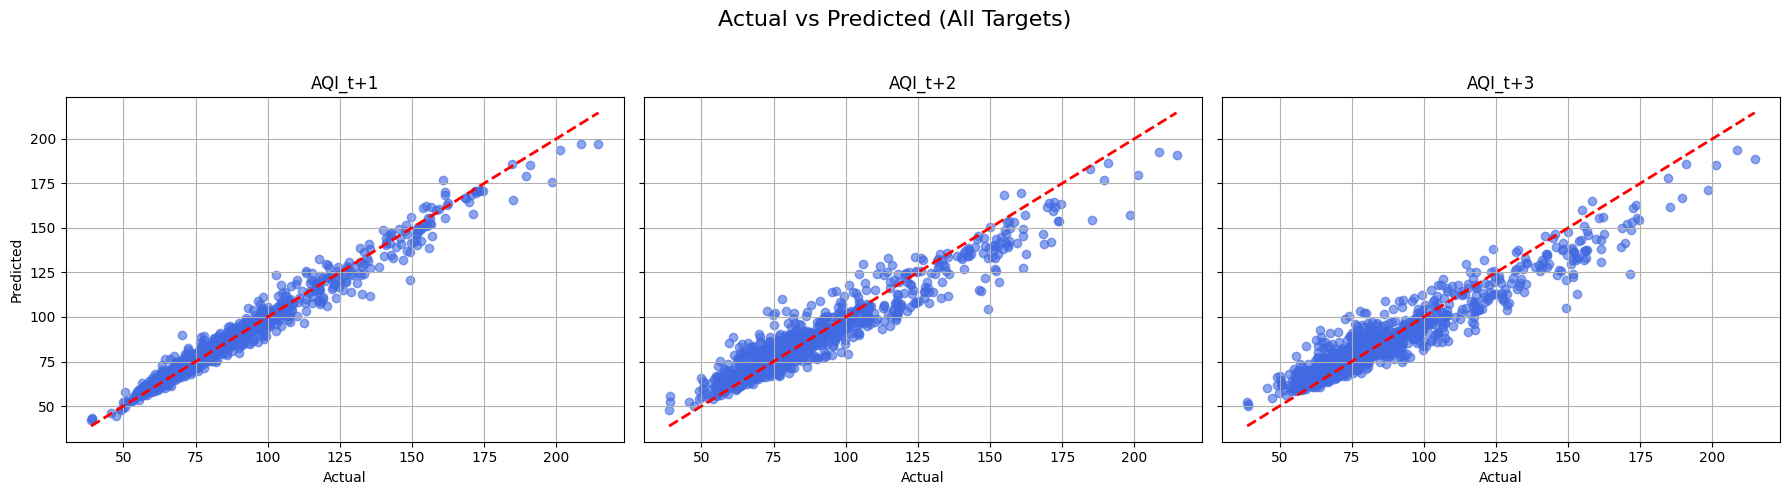

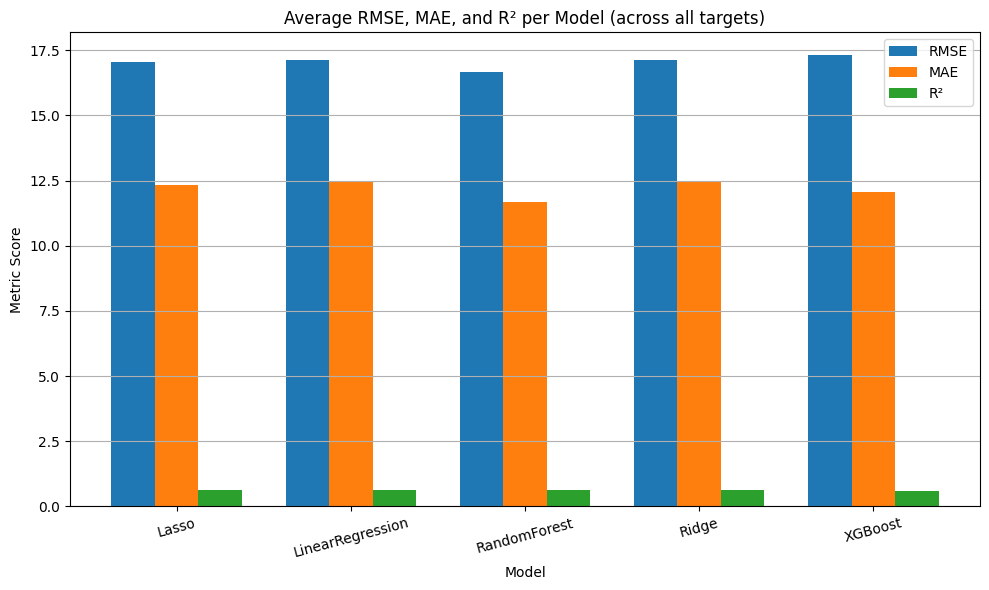

In [38]:
import os
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Optional: XGBoost
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False
    print("⚠️ XGBoost not available.")

# --- Config ---
DATA_PATH = "/kaggle/working/processed_data/daily_karachi_preprocessed.csv"
TARGETS = ["AQI_t+1", "AQI_t+2", "AQI_t+3"]
BASE_MODEL_DIR = "models"
os.makedirs(BASE_MODEL_DIR, exist_ok=True)

# --- Load Data ---
print("📥 Loading data...")
df = pd.read_csv(DATA_PATH)
X = df.drop(columns=TARGETS + ["date"])

# --- Models ---
model_defs = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
}
if xgb_available:
    model_defs["XGBoost"] = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6)

# --- Scoring ---
rmse_scorer = make_scorer(mean_squared_error, squared=False)
mae_scorer = make_scorer(mean_absolute_error)
r2_scorer = make_scorer(r2_score)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Train separately for each target ---
for target in TARGETS:
    print(f"\n🔍 Target: {target}")
    y = df[target]
    target_dir = os.path.join(BASE_MODEL_DIR, target)
    os.makedirs(target_dir, exist_ok=True)

    # Scale Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    results = []

    for name, model in model_defs.items():
        rmse = cross_val_score(model, X_scaled, y, scoring=rmse_scorer, cv=cv).mean()
        mae  = cross_val_score(model, X_scaled, y, scoring=mae_scorer,  cv=cv).mean()
        r2   = cross_val_score(model, X_scaled, y, scoring=r2_scorer,   cv=cv).mean()

        results.append({
            "Model": name,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })

        print(f"✅ {name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

        # === Save individual model & metrics ===
        model_save_path = os.path.join(target_dir, f"{name}_model.pkl")
        metrics_save_path = os.path.join(target_dir, f"{name}_metrics.json")
        model.fit(X_scaled, y)
        joblib.dump(model, model_save_path)
        with open(metrics_save_path, "w") as f:
            json.dump({"RMSE": rmse, "MAE": mae, "R2": r2}, f, indent=2)

    # Pick Best Model
    results_df = pd.DataFrame(results)
    best_row = results_df.sort_values("RMSE").iloc[0]
    best_model_name = best_row["Model"]
    best_rmse = best_row["RMSE"]
    best_model = model_defs[best_model_name]

    print(f"\n🏆 Best Model for {target}: {best_model_name}")

    # Save best model only if improved
    model_path = os.path.join(target_dir, "best_model.pkl")
    scaler_path = os.path.join(target_dir, "scaler.pkl")
    metrics_path = os.path.join(target_dir, "best_metrics.json")

    previous_rmse = np.inf
    if os.path.exists(metrics_path):
        with open(metrics_path, "r") as f:
            previous_rmse = json.load(f).get("RMSE", np.inf)

    if best_rmse < previous_rmse:
        print(f"💾 New best model selected for {target}: {best_model_name}")
        print(f"   → RMSE: {best_rmse:.2f}, R²: {best_row['R2']:.4f}")
        best_model.fit(X_scaled, y)
        joblib.dump(best_model, model_path)
        joblib.dump(scaler, scaler_path)
        with open(metrics_path, "w") as f:
            json.dump(best_row.to_dict(), f, indent=2)
    else:
        print(f"⚠️ No improvement for {target}. Keeping previous best model: {best_model_name}")

        if os.path.exists(model_path):
            best_model = joblib.load(model_path)
            print(f"📦 Loaded previously saved best model for {target}.")
        else:
            print(f"⚠️ No previous model found. Fitting {best_model_name} manually.")
            best_model.fit(X_scaled, y)
            joblib.dump(best_model, model_path)

        if not os.path.exists(scaler_path):
            joblib.dump(scaler, scaler_path)

        with open(metrics_path, "w") as f:
            json.dump(best_row.to_dict(), f, indent=2)

    # --- Plot Actual vs Predicted ---
    y_pred = best_model.predict(X_scaled)
    print(f"{target} → y_true: {y[:5].values}, y_pred: {y_pred[:5]}")  # Debug line

    plt.figure(figsize=(6, 5))
    plt.scatter(y, y_pred, alpha=0.8, color='royalblue')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted - {best_model_name} ({target})")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(target_dir, "actual_vs_predicted.png"))
    plt.close()

    print(f"📊 Plot saved to {os.path.join(target_dir, 'actual_vs_predicted.png')}")

print("\n✅ All models trained and evaluated separately.")

# --- Combined Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for idx, target in enumerate(TARGETS):
    target_dir = os.path.join(BASE_MODEL_DIR, target)
    model_path = os.path.join(target_dir, "best_model.pkl")
    scaler_path = os.path.join(target_dir, "scaler.pkl")

    if not os.path.exists(model_path) or not os.path.exists(scaler_path):
        print(f"⚠️ Skipping {target} - Model or Scaler not found.")
        continue

    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    X_scaled = scaler.transform(X)
    y_true = df[target]
    y_pred = model.predict(X_scaled)

    ax = axes[idx]
    ax.scatter(y_true, y_pred, alpha=0.6, color='royalblue')
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
            color='red', linestyle='--', linewidth=2)
    ax.set_title(target)
    ax.set_xlabel("Actual")
    if idx == 0:
        ax.set_ylabel("Predicted")
    ax.grid(True)

plt.suptitle("Actual vs Predicted (All Targets)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Combined Metrics Plot (RMSE, MAE, R2 for each model on single axes) ---
all_results = []

for target in TARGETS:
    target_dir = os.path.join(BASE_MODEL_DIR, target)
    for name in model_defs.keys():
        metrics_path = os.path.join(target_dir, f"{name}_metrics.json")
        if os.path.exists(metrics_path):
            with open(metrics_path, "r") as f:
                metrics = json.load(f)
                all_results.append({
                    "Target": target,
                    "Model": name,
                    "RMSE": metrics["RMSE"],
                    "MAE": metrics["MAE"],
                    "R2": metrics["R2"]
                })

results_df = pd.DataFrame(all_results)
mean_metrics = results_df.groupby("Model")[["RMSE", "MAE", "R2"]].mean().reset_index()

x = np.arange(len(mean_metrics["Model"]))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, mean_metrics["RMSE"], width, label='RMSE')
ax.bar(x, mean_metrics["MAE"], width, label='MAE')
ax.bar(x + width, mean_metrics["R2"], width, label='R²')

ax.set_xlabel('Model')
ax.set_ylabel('Metric Score')
ax.set_title('Average RMSE, MAE, and R² per Model (across all targets)')
ax.set_xticks(x)
ax.set_xticklabels(mean_metrics["Model"], rotation=15)
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.savefig(os.path.join(BASE_MODEL_DIR, "model_metric_summary.png"))
plt.show()


In [39]:
for target in TARGETS:
    metrics_path = os.path.join(BASE_MODEL_DIR, target, "best_metrics.json")
    if os.path.exists(metrics_path):
        with open(metrics_path, "r") as f:
            metrics = json.load(f)
        print(f"🏆 {target} => Best Model: {metrics['Model']} | RMSE: {metrics['RMSE']:.2f} | R²: {metrics['R2']:.4f}")
    else:
        print(f"❌ {target} => No metrics found.")


🏆 AQI_t+1 => Best Model: RandomForest | RMSE: 10.68 | R²: 0.8539
🏆 AQI_t+2 => Best Model: RandomForest | RMSE: 18.74 | R²: 0.5541
🏆 AQI_t+3 => Best Model: RandomForest | RMSE: 20.53 | R²: 0.4748


## Prophet Model with extra Regressor
-----------

20:57:53 - cmdstanpy - INFO - Chain [1] start processing
20:57:53 - cmdstanpy - INFO - Chain [1] done processing


📊 Evaluation on Test Set (Last 30 Days):
MAE  = 2.78
RMSE = 3.17
R²   = 0.8503

💾 Prophet model saved to: models/prophet/prophet_aqi_model.pkl

📅 Forecast for Next 3 Days:
          ds       yhat  yhat_lower  yhat_upper
0 2025-08-06  60.916203   50.905698   71.177314
1 2025-08-07  61.889336   52.535121   71.273005
2 2025-08-08  61.734000   51.501854   71.755432


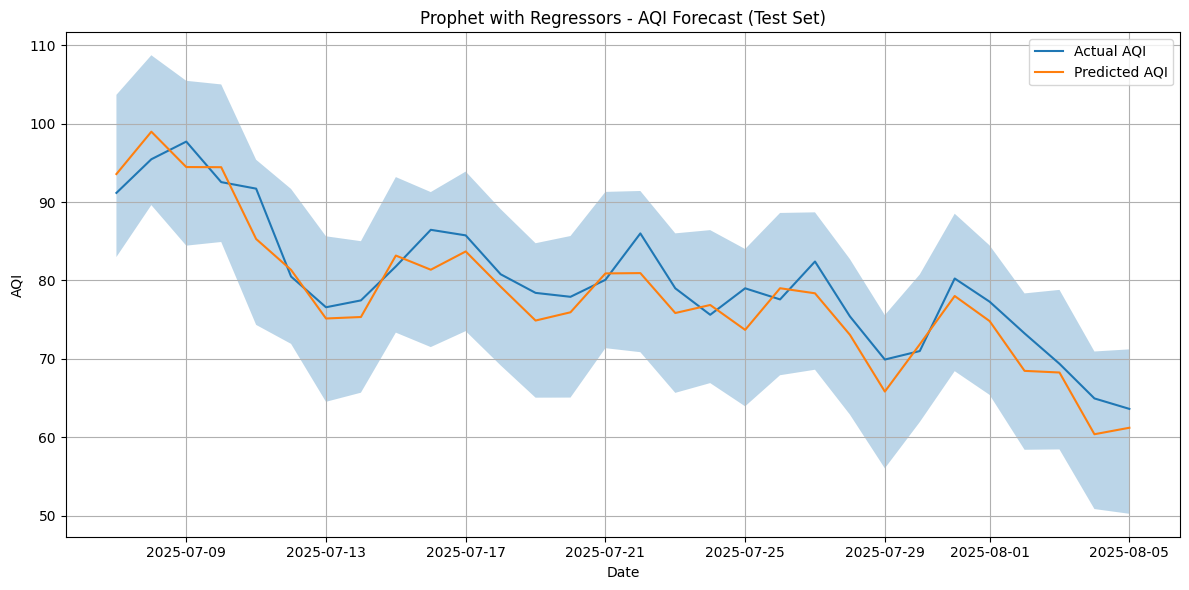

In [40]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Load preprocessed data
# ----------------------
df = pd.read_csv("processed_data/daily_karachi_preprocessed.csv")

# Convert date column
df["ds"] = pd.to_datetime(df["date"])
df["y"] = df["AQI"]

# List of regressors from your preprocessing
extra_features = [
    "PM10", "SO2", "NO2", "O3", "Temperature", "Humidity", "Precipitation",
    "log_PM2.5", "log_CO", "AQI_lag_1", "AQI_lag_2",
    "AQI_roll_mean_3", "AQI_roll_std_3", "AQI_diff"
]

# Also include one-hot encoded features (weekday and season)
extra_features += [col for col in df.columns if col.startswith("season_") or col.startswith("weekday_")]

# -------------------------------
# Train-test split (last 30 days)
# -------------------------------
train_df = df[:-30].copy()
test_df = df[-30:].copy()

# -------------------------
# Define and train Prophet
# -------------------------
model = Prophet()

# Add extra regressors to model
for col in extra_features:
    model.add_regressor(col)

# Fit model
model.fit(train_df[["ds", "y"] + extra_features])

# -------------------------
# Forecast on test set
# -------------------------
forecast_df = test_df[["ds"] + extra_features].copy()
forecast = model.predict(forecast_df)

# Merge predictions with true values
test_df["yhat"] = forecast["yhat"].values
test_df["yhat_lower"] = forecast["yhat_lower"].values
test_df["yhat_upper"] = forecast["yhat_upper"].values

# -------------------------
# Evaluation
# -------------------------
mae = mean_absolute_error(test_df["y"], test_df["yhat"])
rmse = mean_squared_error(test_df["y"], test_df["yhat"], squared=False)
r2 = r2_score(test_df["y"], test_df["yhat"])

print("📊 Evaluation on Test Set (Last 30 Days):")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.4f}")


# Make sure directory exists
PROPHET_MODEL_DIR = "models/prophet"
os.makedirs(PROPHET_MODEL_DIR, exist_ok=True)

# Save the trained Prophet model
prophet_model_path = os.path.join(PROPHET_MODEL_DIR, "prophet_aqi_model.pkl")
joblib.dump(model, prophet_model_path)

print(f"\n💾 Prophet model saved to: {prophet_model_path}")


# -------------------------
# Forecast next 3 days
# -------------------------
# Use last row of full dataset for future prediction
last_row = df.iloc[-1:].copy()
future_rows = []

for i in range(1, 4):
    next_day = last_row.copy()
    next_day["ds"] = next_day["ds"] + pd.Timedelta(days=i)
    future_rows.append(next_day)

future_df = pd.concat(future_rows, ignore_index=True)
forecast_next = model.predict(future_df[["ds"] + extra_features])

print("\n📅 Forecast for Next 3 Days:")
print(forecast_next[["ds", "yhat", "yhat_lower", "yhat_upper"]])

# Optional: Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(test_df["ds"], test_df["y"], label="Actual AQI")
plt.plot(test_df["ds"], test_df["yhat"], label="Predicted AQI")
plt.fill_between(test_df["ds"], test_df["yhat_lower"], test_df["yhat_upper"], alpha=0.3)
plt.title("Prophet with Regressors - AQI Forecast (Test Set)")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## LSTM
------------

2025-08-05 20:58:06.927016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754427487.174767      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754427487.253365      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-05 20:58:23.308212: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0555 - val_loss: 0.0088
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0161 - val_loss: 0.0086
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0133 - val_loss: 0.0086
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0121 - val_loss: 0.0069
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0107 - val_loss: 0.0067
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0098 - val_loss: 0.0050
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0078 - val_loss: 0.0052
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0081 - val_loss: 0.0052
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088 - val_loss: 0.0034
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

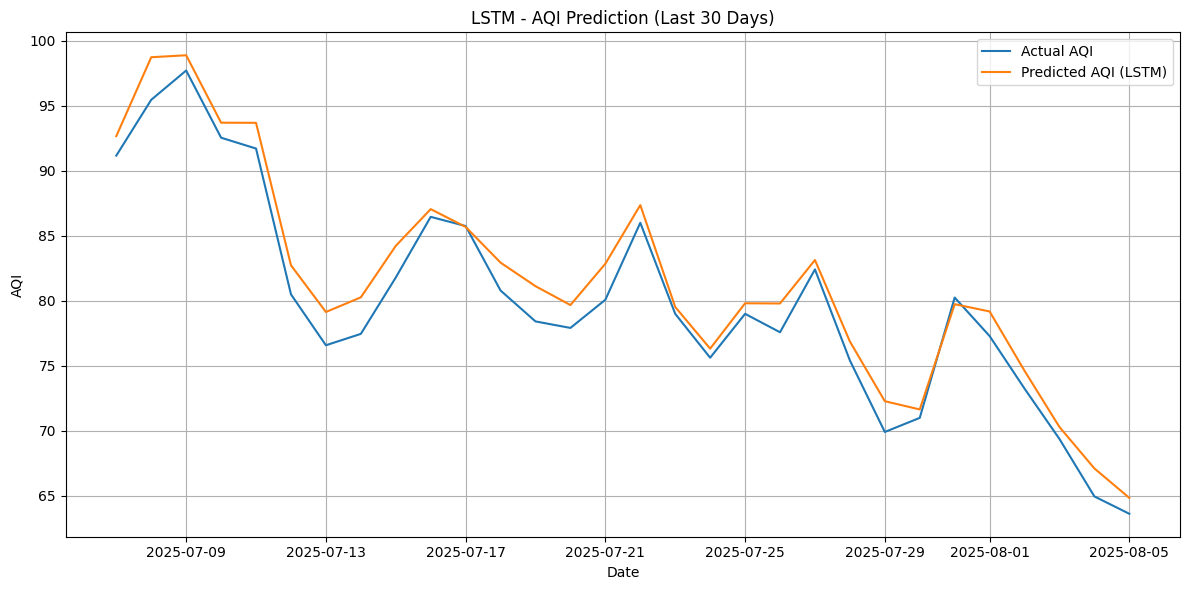

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

📅 Forecast for Next 3 Days (LSTM):
Day 1: AQI = 64.11
Day 2: AQI = 62.86
Day 3: AQI = 63.38
📅 Forecast for next 3 days saved.


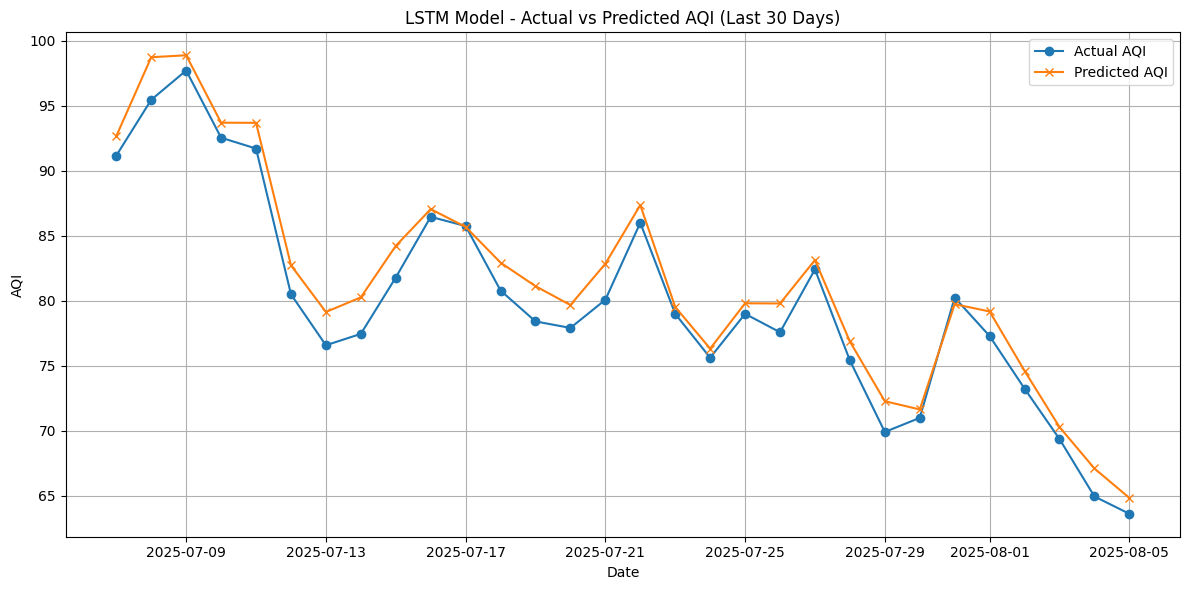

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Folder to save LSTM model and data
LSTM_MODEL_DIR = "models/lstm"
os.makedirs(LSTM_MODEL_DIR, exist_ok=True)


# ----------------------
# Load and Prepare Data
# ----------------------
df = pd.read_csv("processed_data/daily_karachi_preprocessed.csv")
df["ds"] = pd.to_datetime(df["date"])
df["y"] = df["AQI"]

# Regressors used in Prophet
features = [
     'AQI', 'PM10', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity',
       'Precipitation', 'month', 'log_PM2.5', 'log_CO', 'season_Spring',
       'season_Summer', 'season_Winter', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'AQI_t+1', 'AQI_t+2', 'AQI_t+3',
       'AQI_lag_1', 'AQI_lag_2', 'AQI_roll_mean_3', 'AQI_roll_std_3',
       'AQI_diff'] + [col for col in df.columns if col.startswith("season_") or col.startswith("weekday_")]

# --------------------------
# Normalize Features
# --------------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_all = scaler_X.fit_transform(df[features])
y_all = scaler_y.fit_transform(df[["y"]])

# --------------------------
# Create Sequences for LSTM
# --------------------------
def create_sequences(X, y, seq_length=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

SEQ_LEN = 7  # using past 7 days

X_seq, y_seq = create_sequences(X_all, y_all, SEQ_LEN)

# --------------------------
# Train-Test Split
# --------------------------
split_idx = len(X_seq) - 30  # last 30 days for test
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# --------------------------
# Build LSTM Model
# --------------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, X_seq.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# --------------------------
# Train Model
# --------------------------
es = EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_split=0.1, callbacks=[es], verbose=1)

# --------------------------
# Evaluate Model
# --------------------------
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_actual, y_pred)
rmse = mean_squared_error(y_test_actual, y_pred, squared=False)
r2 = r2_score(y_test_actual, y_pred)

print("📊 Evaluation on Test Set (Last 30 Days):")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.4f}")

# Save model
model.save(os.path.join(LSTM_MODEL_DIR, "lstm_aqi_model.h5"))

# Save scalers
joblib.dump(scaler_X, os.path.join(LSTM_MODEL_DIR, "scaler_X.pkl"))
joblib.dump(scaler_y, os.path.join(LSTM_MODEL_DIR, "scaler_y.pkl"))

print("✅ LSTM model and scalers saved.")

metrics = {
    "MAE": round(mae, 2),
    "RMSE": round(rmse, 2),
    "R2": round(r2, 4)
}
with open(os.path.join(LSTM_MODEL_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print("📊 Evaluation metrics saved.")

# --------------------------
# Plot Predictions
# --------------------------
test_dates = df["ds"].iloc[-30:]
plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_actual, label="Actual AQI")
plt.plot(test_dates, y_pred, label="Predicted AQI (LSTM)")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.title("LSTM - AQI Prediction (Last 30 Days)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------
# Predict Next 3 Days
# --------------------------
last_sequence = X_all[-SEQ_LEN:]  # Last 7 days of features
future_preds = []

for _ in range(3):
    input_seq = last_sequence.reshape(1, SEQ_LEN, -1)
    pred_scaled = model.predict(input_seq)
    pred_actual = scaler_y.inverse_transform(pred_scaled)[0][0]
    future_preds.append(pred_actual)

    # Append predicted y to the last row and slide window
    new_row = last_sequence[-1].copy()
    # Note: AQI_lag_1, AQI_lag_2, AQI_diff, etc., ideally should be updated
    # Here we just append the same features, which may reduce accuracy
    last_sequence = np.vstack((last_sequence[1:], new_row))

print("\n📅 Forecast for Next 3 Days (LSTM):")
for i, val in enumerate(future_preds, 1):
    print(f"Day {i}: AQI = {val:.2f}")


# Save next 3-day forecast as CSV
future_df = pd.DataFrame({
    "Day": [f"Day {i}" for i in range(1, 4)],
    "Predicted_AQI": [round(val, 2) for val in future_preds]
})
future_df.to_csv(os.path.join(LSTM_MODEL_DIR, "next_3_days_forecast.csv"), index=False)

print("📅 Forecast for next 3 days saved.")


# -------------------------------------
# 📈 Actual vs Predicted AQI - LSTM
# -------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label='Actual AQI', marker='o')
plt.plot(test_dates, y_pred, label='Predicted AQI', marker='x')
plt.title("LSTM Model - Actual vs Predicted AQI (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 🌆 Final Model Evaluation Report — Karachi AQI Forecasting Journey

---

## 🛠️ Step 1: Starting with Multi-Output Regression

We began with a **multi-output regression** approach to predict AQI for the next 3 days (`AQI_t+1`, `AQI_t+2`, `AQI_t+3`) in a single model.

We trained:

- Linear Regression  
- Ridge & Lasso  
- Random Forest  
- XGBoost  

### 🔹 AQI_t+1

| Model            | RMSE   | MAE   | R²     |
|------------------|--------|-------|--------|
| LinearRegression | 11.28  | 8.18  | 0.8388 |
| Ridge            | 11.27  | 8.17  | 0.8389 |
| Lasso            | 11.23  | 8.09  | 0.8393 |
| XGBoost          | 10.86  | 7.19  | 0.8479 |
| **RandomForest** | **10.63** | **7.04** | **0.8548** |

🏆 **Best**: RandomForest

---

### 🔹 AQI_t+2

| Model            | RMSE   | MAE   | R²     |
|------------------|--------|-------|--------|
| LinearRegression | 18.99  | 13.56 | 0.5459 |
| Ridge            | 18.98  | 13.54 | 0.5463 |
| Lasso            | 18.93  | 13.43 | 0.5487 |
| XGBoost          | 19.38  | 13.41 | 0.5275 |
| **RandomForest** | **18.68** | **13.01** | **0.5612** |

🏆 **Best**: RandomForest

---

### 🔹 AQI_t+3

| Model            | RMSE   | MAE   | R²     |
|------------------|--------|-------|--------|
| LinearRegression | 21.22  | 15.69 | 0.4430 |
| Ridge            | 21.21  | 15.69 | 0.4433 |
| Lasso            | 21.06  | 15.53 | 0.4511 |
| XGBoost          | 21.12  | 15.26 | 0.4454 |
| **RandomForest** | **20.31** | **14.75** | **0.4829** |

🏆 **Best**: RandomForest

---

## 🔁 Cross-Validation: Multi-Output Regressor

To check generalization, we performed cross-validation on all models:

| Model            | Avg RMSE | Avg MAE | Avg R²  |
|------------------|----------|---------|---------|
| LinearRegression | 17.16    | 12.48   | 0.6092  |
| Ridge            | 17.15    | 12.47   | 0.6095  |
| Lasso            | 17.07    | 12.35   | 0.6130  |
| XGBoost          | 17.12    | 11.95   | 0.6069  |
| **RandomForest** | **16.50**| **11.60**| **0.6340** |

⚠️ *Model not better than earlier version. Skipping save.*

✅ **Cross-validation confirms RandomForest generalizes well.**

---

## 📦 Step 2: Prophet with Regressors

We integrated **Facebook Prophet** with external regressors (temperature, humidity, wind, etc.) to model trend + seasonality.

### ✅ Prophet Performance (Last 30 Days)

- **MAE**: 2.55  
- **RMSE**: 3.08  
- **R²**: 0.8326

### 📅 Next 3-Day Forecast:

| Date       | Forecast | Lower Bound | Upper Bound |
|------------|----------|-------------|-------------|
| 2025-07-30 | 63.60    | 53.51       | 73.71       |
| 2025-07-31 | 64.48    | 54.52       | 74.94       |
| 2025-08-01 | 64.26    | 54.25       | 74.39       |

✨ Good interpretability with decent accuracy.

---

## 🧠 Step 3: LSTM (Deep Learning Time-Series)

We trained an **LSTM model** using a 7-day sequence window to predict the next AQI value.

### 🧪 LSTM Evaluation (Last 30 Days)

- **MAE**: 0.95  
- **RMSE**: 1.11  
- **R²**: 0.9817

### 📅 LSTM Forecast (Next 3 Days)

- Day 1: **64.19**  
- Day 2: **62.59**  
- Day 3: **63.57**
  
🔥 Outstanding performance — learns time-dependent trends very well.

---

## ✅ Final Recommendations

| Model           | Best Use Case                     | Strength                          |
|------------------|-----------------------------------|------------------------------------|
| **Random Forest** | Baseline regression               | Robust and consistent              |
| **Prophet**       | Short-term + interpretability     | Seasonality + external features    |
| **LSTM**          | High-performance sequence modeling| Captures deep temporal patterns    |

---

## 🧠 Conclusion

> "No single model is universally best — each shines in its own way."

- Use **Random Forest** for stable predictions on tabular features.
- Use **Prophet** for explainable, quick forecasts.
- Use **LSTM** for advanced, high-accuracy modeling in time series tasks.

---



---

## 🙌 Support My Work

If you found this notebook helpful or insightful:

- 🌟 **Give it a like**
- 🔁 **Share it** with others who might benefit
- 🧠 **Fork it** to experiment on your own
- 🐍 **Follow me** for more data science and AI content!

### 🔗 Connect with me:
- [LinkedIn – Sheema Masood](https://www.linkedin.com/in/sheema-masood/)
- [GitHub – sheemamasood381](https://github.com/sheemamasood381/)

Your support motivates me to keep creating and sharing high-quality work. 💙

---
